# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb

---

# Setup

In [4]:
cd ../..

/Users/shanekercheval/repos/nlp-template


In [5]:
%run "source/config/notebook_settings.py"

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
from source.library.utilities import Timer, get_logger
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, count_keywords, count_keywords_by, impurity

In [8]:
with Timer("Loading Data"):
    path = 'artifacts/data/processed/un-general-debates-paragraphs.pkl'
    paragraphs = pd.read_pickle(path)

Started: Loading Data
Finished (0.23 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [10]:
hlp.pandas.numeric_summary(paragraphs)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
year,"279,045",0,0.0%,0,0.0%,"1,992.4",12.6,0.0,0.1,-1.1,"1,970","1,975.0","1,982.0","1,993.0","2,003.0","2,010.0","2,015"


In [11]:
hlp.pandas.non_numeric_summary(paragraphs)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"279,045",0,0.0%,Russian Federation,199,0.1%
text,"279,045",0,0.0%,The President returned to the [...],"278,820",99.9%


In [12]:
assert not (paragraphs['text'].str.strip() == '').any()

# Prep

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

## Sample

In [21]:
paragraphs = paragraphs.sample(2000)

## TF

`TF` seems to be used with `LDA` rather than `TF-IDF`

In [20]:
with Timer("Calculating TF (uni-grams and bi-grams) for UN Debate Paragraphs"):
    count_vectorizer_unigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    count_vectors_unigrams = count_vectorizer_unigrams.fit_transform(paragraphs["text"])
    count_vectors_unigrams.shape

    count_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, ngram_range=(2, 3), min_df=5, max_df=0.7)
    count_vectors_bigrams = count_vectorizer_bigrams.fit_transform(paragraphs["text"])
    count_vectors_bigrams.shape

Started: Calculating TF (uni-grams and bi-grams) for UN Debate Paragraphs
Finished (0.22 seconds)


## TF-IDF

In [22]:
with Timer("Calculating TF-IDF (uni-grams and bi-grams) for UN Debate Paragraphs"):
    tfidf_vectorizer_unigrams = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    tfidf_vectors_unigrams = tfidf_vectorizer_unigrams.fit_transform(paragraphs["text"])
    tfidf_vectors_unigrams.shape
    
    tfidf_vectorizer_bigrams = TfidfVectorizer(stop_words=stopwords, ngram_range=(2, 3), min_df=5, max_df=0.7)
    tfidf_vectors_bigrams = tfidf_vectorizer_bigrams.fit_transform(paragraphs["text"])
    tfidf_vectors_bigrams.shape

Started: Calculating TF-IDF (uni-grams and bi-grams) for UN Debate Paragraphs
Finished (0.22 seconds)


# Topic Modeling

In [27]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



In [28]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## NMF

### Uni-grams

In [73]:
from sklearn.decomposition import NMF

nmf_unigrams = NMF(n_components=10, random_state=42)
# see Blueprints pg. 214 for explaination of W X H
w_matrix_unigrams = nmf_unigrams.fit_transform(tfidf_vectors_unigrams)
h_matrix_unigrams = nmf_unigrams.components_
word_names = tfidf_vectorizer_unigrams.get_feature_names_out()

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [34]:
print(w_matrix_unigrams.shape)
print(h_matrix_unigrams.shape)

(2000, 10)
(10, 2674)


Get Topic Weightings for First Doc

In [43]:
# topics for first document 
w_first_doc = w_matrix_unigrams[0, ]
w_first_doc

array([0.        , 0.        , 0.10318821, 0.        , 0.00071892,
       0.        , 0.08254518, 0.        , 0.02788856, 0.07351074])

In [44]:
# Should be the same values as before
predictions_first_doc = nmf_unigrams.transform(tfidf_vectors_unigrams[0,])
predictions_first_doc

array([[0.        , 0.        , 0.10318972, 0.        , 0.0007197 ,
        0.        , 0.08254613, 0.        , 0.02788199, 0.07351027]])

In [61]:
[abs(round(x, 4)) for x in (w_first_doc - predictions_first_doc).tolist()[0]]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

---

Get Top 10 Words for First Topic

In [66]:
first_topic = h_matrix_unigrams[0,]
first_topic.shape

(2674,)

In [76]:
largest_word_values = first_topic.argsort()[::-1]
largest_word_values[0:10]

array([1359, 2212,  505,  620, 1784, 2442, 2344, 2073, 1728,  473])

In [77]:
word_names[largest_word_values[0:10]]

array(['international', 'security', 'community', 'council', 'peace',
       'terrorism', 'states', 'relations', 'order', 'co'], dtype=object)

---

Size of Topics (Percent of all Documents)

In [78]:
w_matrix_unigrams.sum(axis=0)/w_matrix_unigrams.sum()*100.0

array([ 9.78388081,  9.38825492,  9.39631062, 14.24242548,  6.73081249,
        8.54015407,  7.50892734,  8.92569105, 14.85705681, 10.62648643])

---

In [162]:
def parse_topics(model, features, no_top_words=10):
    topics = dict()
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        topics[topic + 1] = [(features[largest[i]], abs(words[largest[i]]*100.0/total)) for i in range(0, no_top_words)]
    return topics

In [163]:
topic_dictionary = parse_topics(nmf_unigrams, tfidf_vectorizer_unigrams.get_feature_names_out())
topic_dictionary

{1: [('international', 3.949219326447293),
  ('security', 2.3139420026449398),
  ('community', 1.703191488149202),
  ('council', 1.4434271342186613),
  ('peace', 1.2571243601573183),
  ('terrorism', 1.0178556670097154),
  ('states', 0.8957379331863327),
  ('relations', 0.7389828788134795),
  ('order', 0.6960736912061108),
  ('co', 0.5745892151673663)],
 2: [('session', 3.3237103733553046),
  ('general', 3.233330226746067),
  ('assembly', 3.164972900764588),
  ('mr', 2.6730560288292984),
  ('president', 1.8122058278250894),
  ('election', 1.7692185913060554),
  ('wish', 1.3304416873049996),
  ('secretary', 1.3074577091352588),
  ('congratulations', 1.2220532461392415),
  ('delegation', 1.1945113885325218)],
 3: [('countries', 5.994704810030081),
  ('developing', 3.017422962886374),
  ('economic', 1.8698409380114942),
  ('developed', 1.7653924215663568),
  ('trade', 0.9902413170225026),
  ('growth', 0.6692234794665246),
  ('economies', 0.655227716093694),
  ('debt', 0.6483590868201459),


In [164]:
name_lookup = {topic:' | '.join([y[0] for y in x[0:3]]) for topic, x in topic_dictionary.items()}

In [165]:
topic_words = pd.DataFrame(topic_dictionary)
topics = topic_words.columns
topic_words = topic_words.reset_index().rename(columns={'index': 'word'})
topic_words = pd.melt(topic_words, id_vars='word', value_vars=list(topics), var_name='topic')
topic_words = topic_words.assign(**pd.DataFrame(topic_words['value'].tolist(), columns=['words', 'value']))
topic_words['label'] = topic_words['topic'].apply(lambda x: name_lookup[x])
topic_words

,word,topic,value,words,label
0,0,1,3.95,international,international | security | community
1,1,1,2.31,security,international | security | community
2,2,1,1.70,community,international | security | community
3,3,1,1.44,council,international | security | community
4,4,1,1.26,peace,international | security | community
...,...,...,...,...,...
95,5,10,1.00,millennium,development | economic | social
96,6,10,0.89,global,development | economic | social
97,7,10,0.78,summit,development | economic | social
98,8,10,0.78,poverty,development | economic | social


In [168]:
import plotly_express as px

fig = px.bar(
    topic_words,
    x='value',
    y='words',
    facet_col='label',
    facet_col_wrap=3,
    facet_col_spacing=0.2,
    labels={'words': ''},
    width=900,
    height=1000,
    title="Topics in NMF model (Unigrams)"
)
fig.update_yaxes(matches=None, showticklabels=True, autorange="reversed")
#fig.update_xaxes(matches=None)
fig.show()

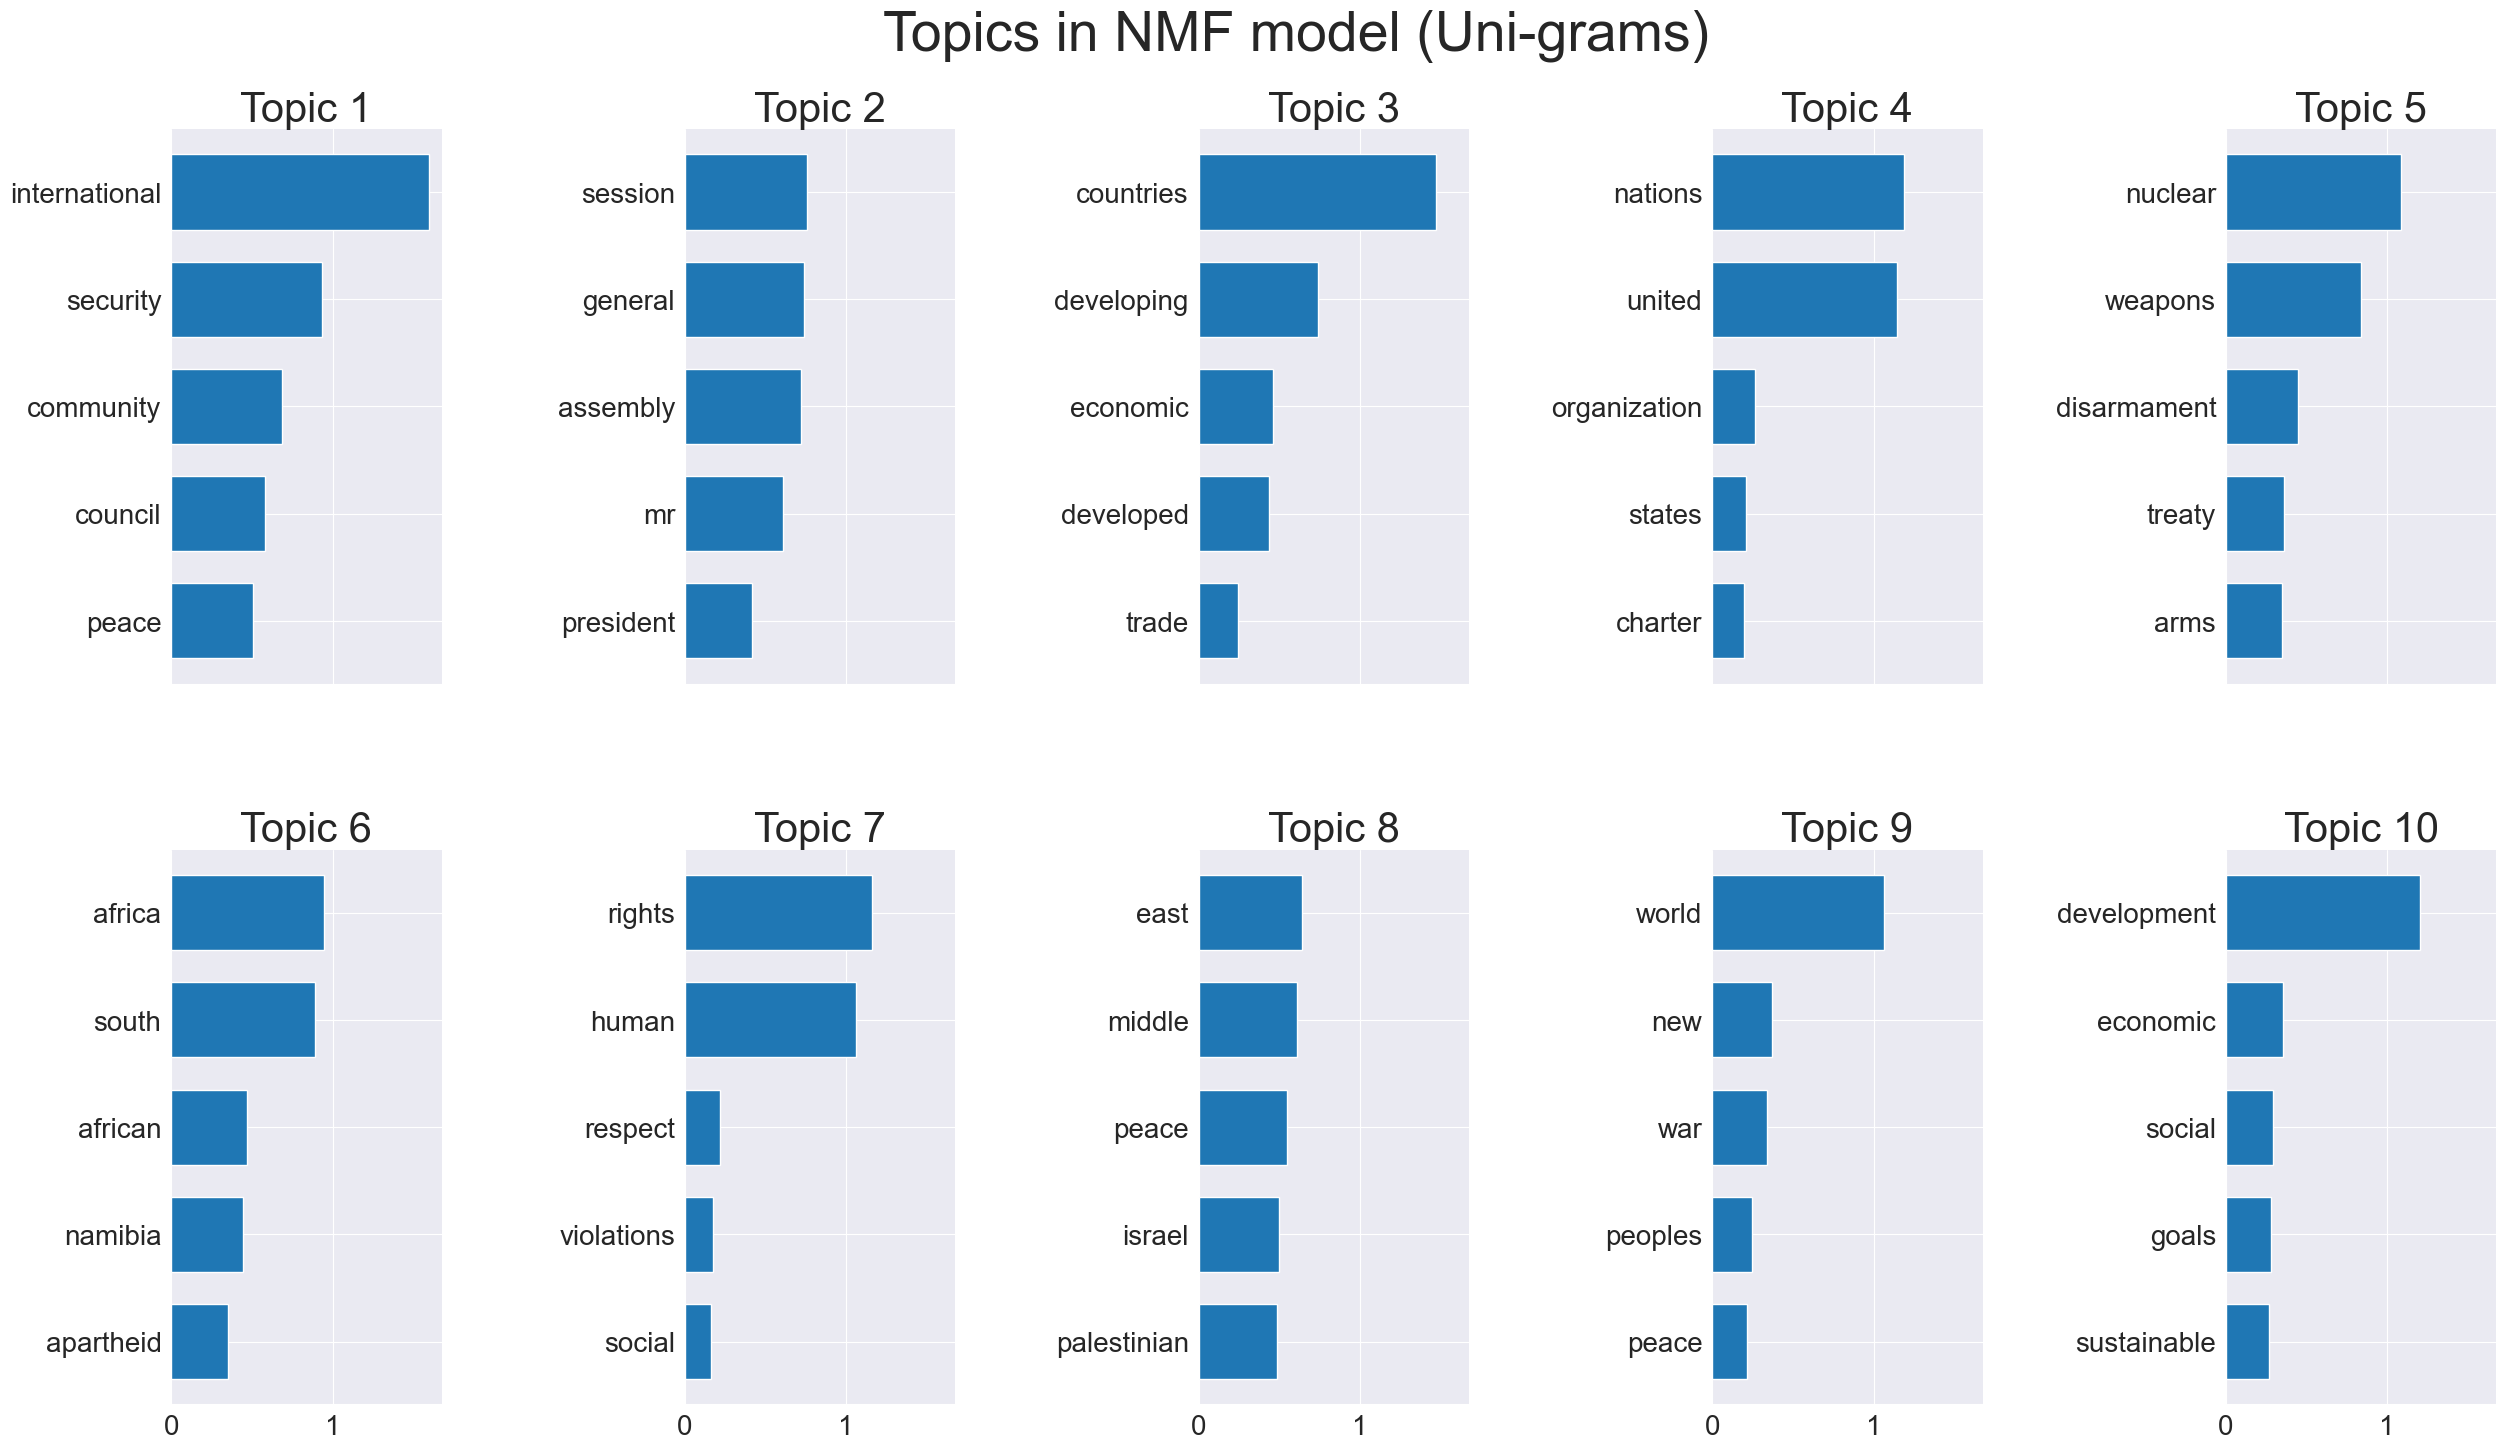

In [31]:
plot_top_words(
    model=nmf_unigrams,
    feature_names=tfidf_vectorizer_unigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in NMF model (Uni-grams)"
)

---

In [53]:
nmf_para_model_bigrams = NMF(n_components=10, random_state=42)
W_para_matrix_bigrams = nmf_para_model_bigrams.fit_transform(tfidf_para_vectors_bigrams)
H_para_matrix_bigrams = nmf_para_model_bigrams.components_

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [61]:
#display_topics(nmf_para_model_bigrams, tfidf_para_vectorizer_bigrams.get_feature_names())

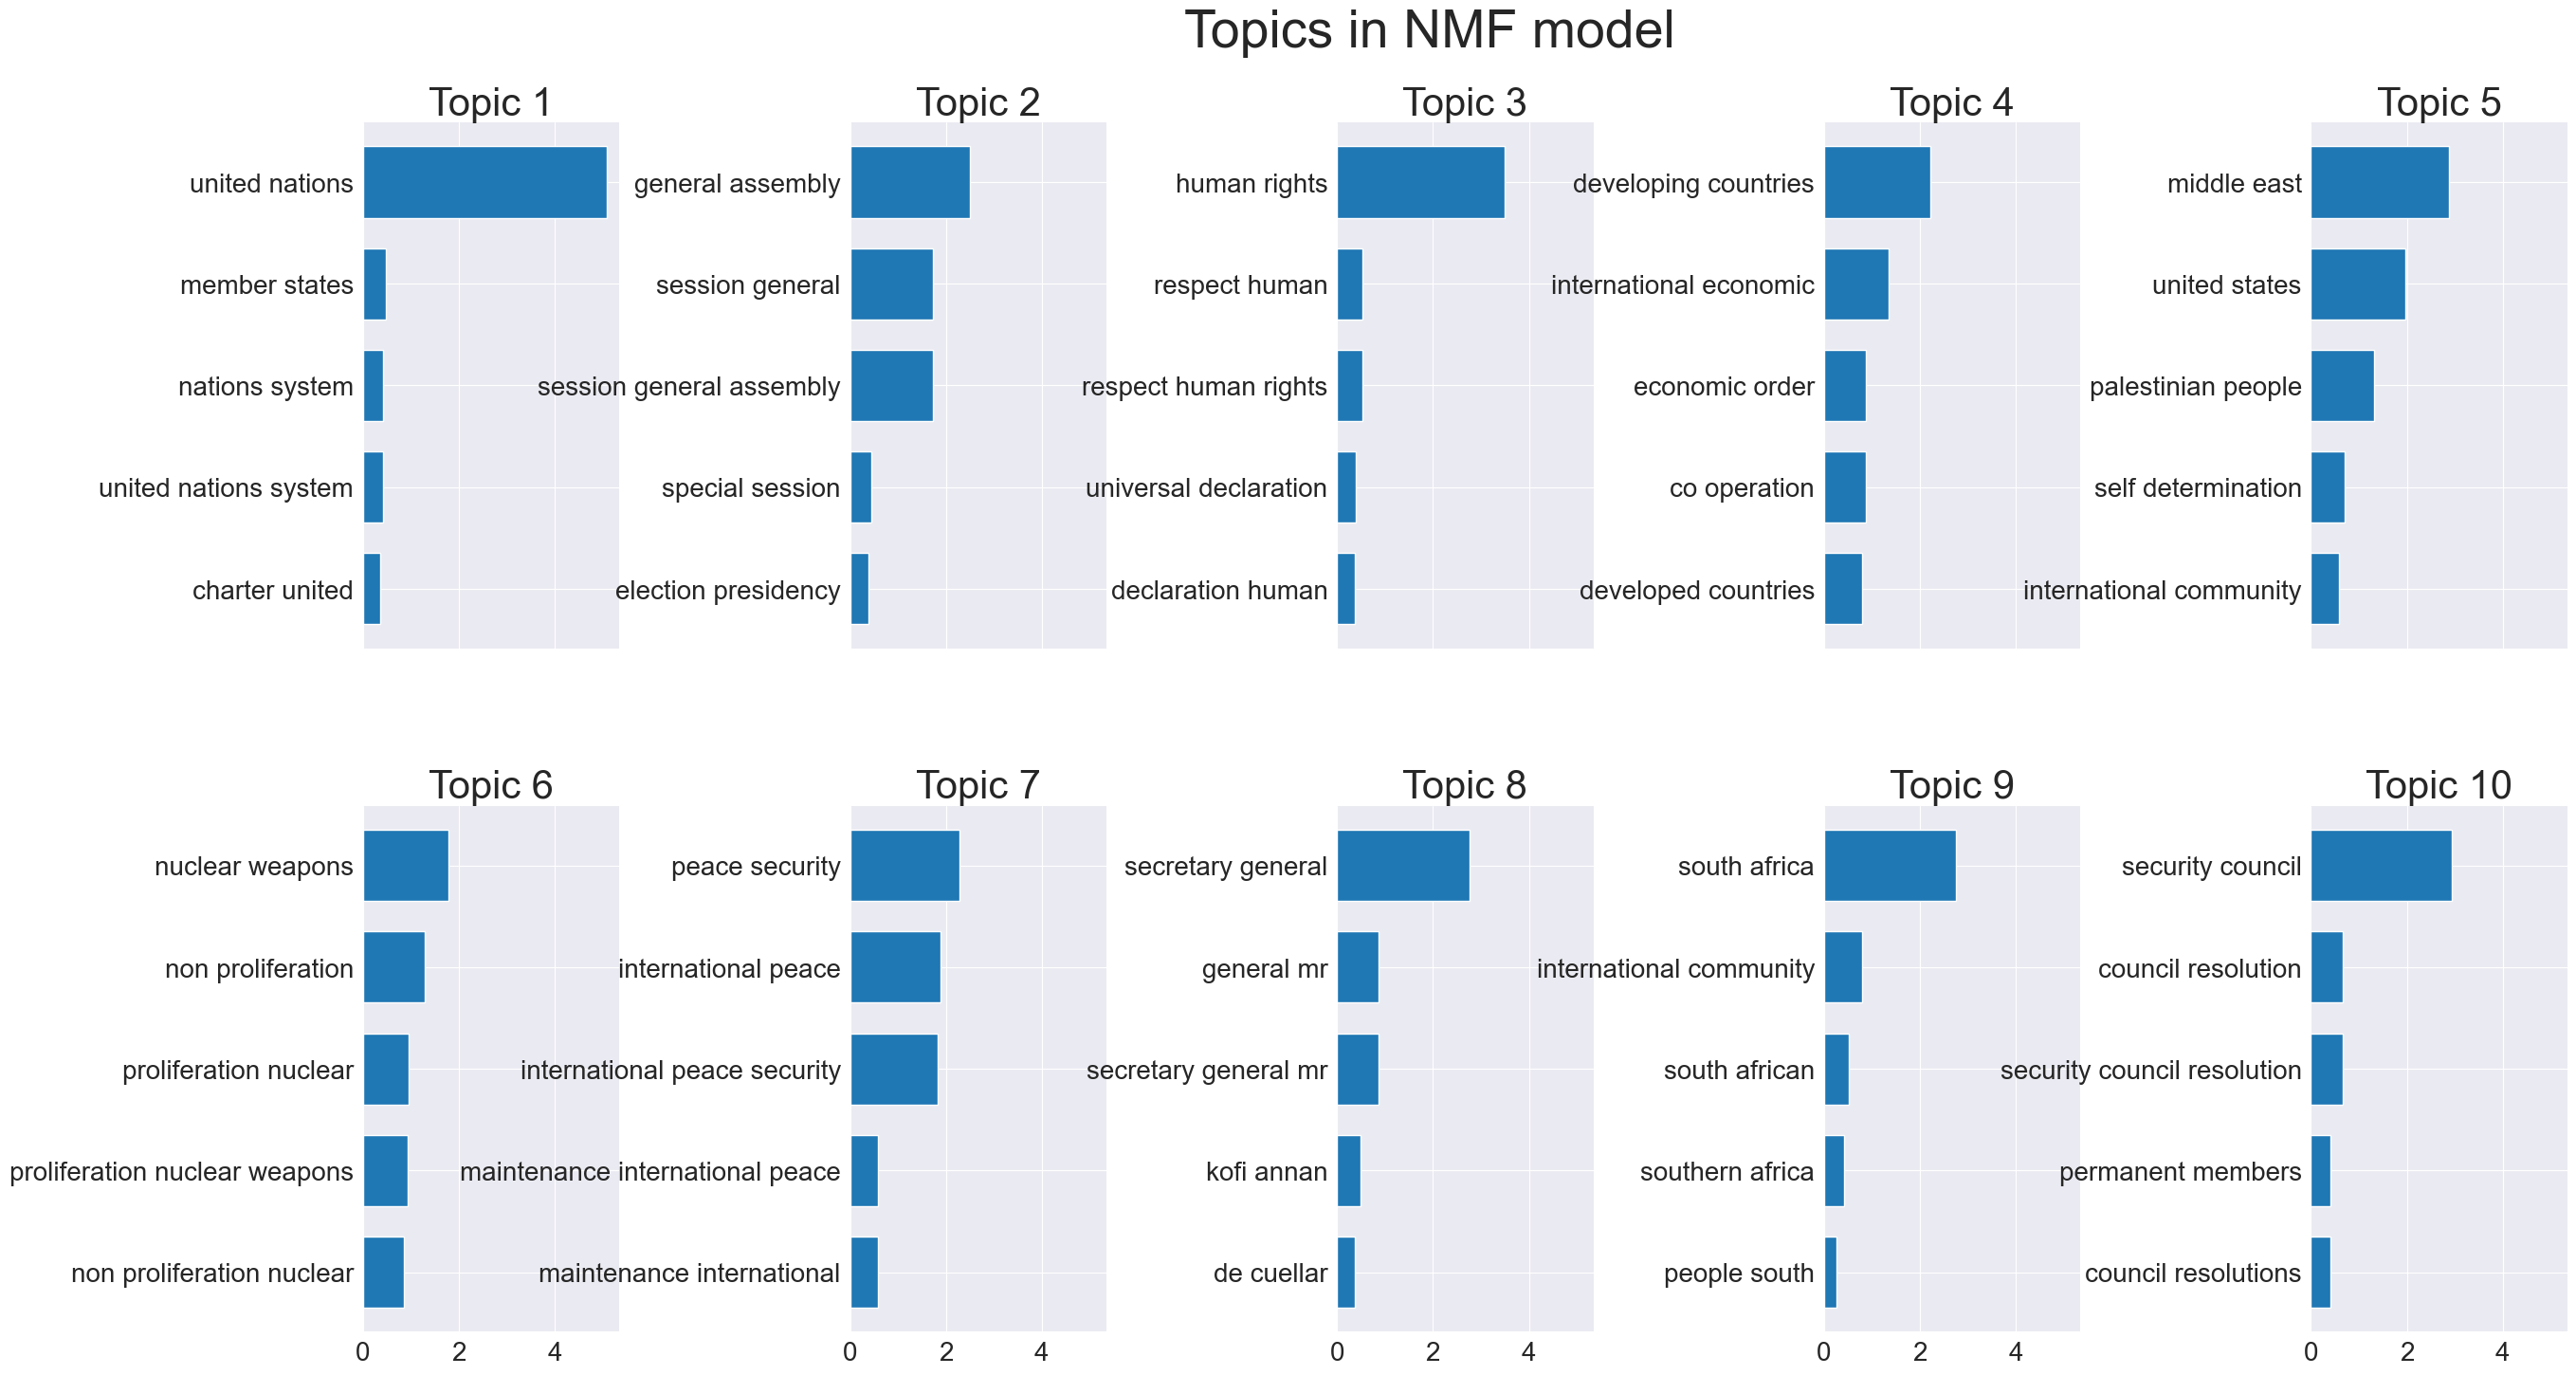

In [62]:
plot_top_words(
    model=nmf_para_model_bigrams,
    feature_names=tfidf_para_vectorizer_bigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in NMF model (Bi-grams)"
)

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

---

Neither the book nor the example above uses TF-IDF with LDA, but do not specify why. Both use TF-IDF with NMF and then change to CountVectorizer with LDA


https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327

> LDA only needs a bag-of-word vector.



In [74]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(2,3))
count_para_vectors_bigrams = count_para_vectorizer_bigrams.fit_transform(paragraphs["text"])
count_para_vectors_bigrams.shape

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279045, 396733)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(2,3))
count_para_vectors_bigrams = count_para_vectorizer_bigrams.fit_transform(paragraphs["text"])
count_para_vectors_bigrams.shape


from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraphs["text"])
count_para_vectors.shape

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279045, 25162)

In [67]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


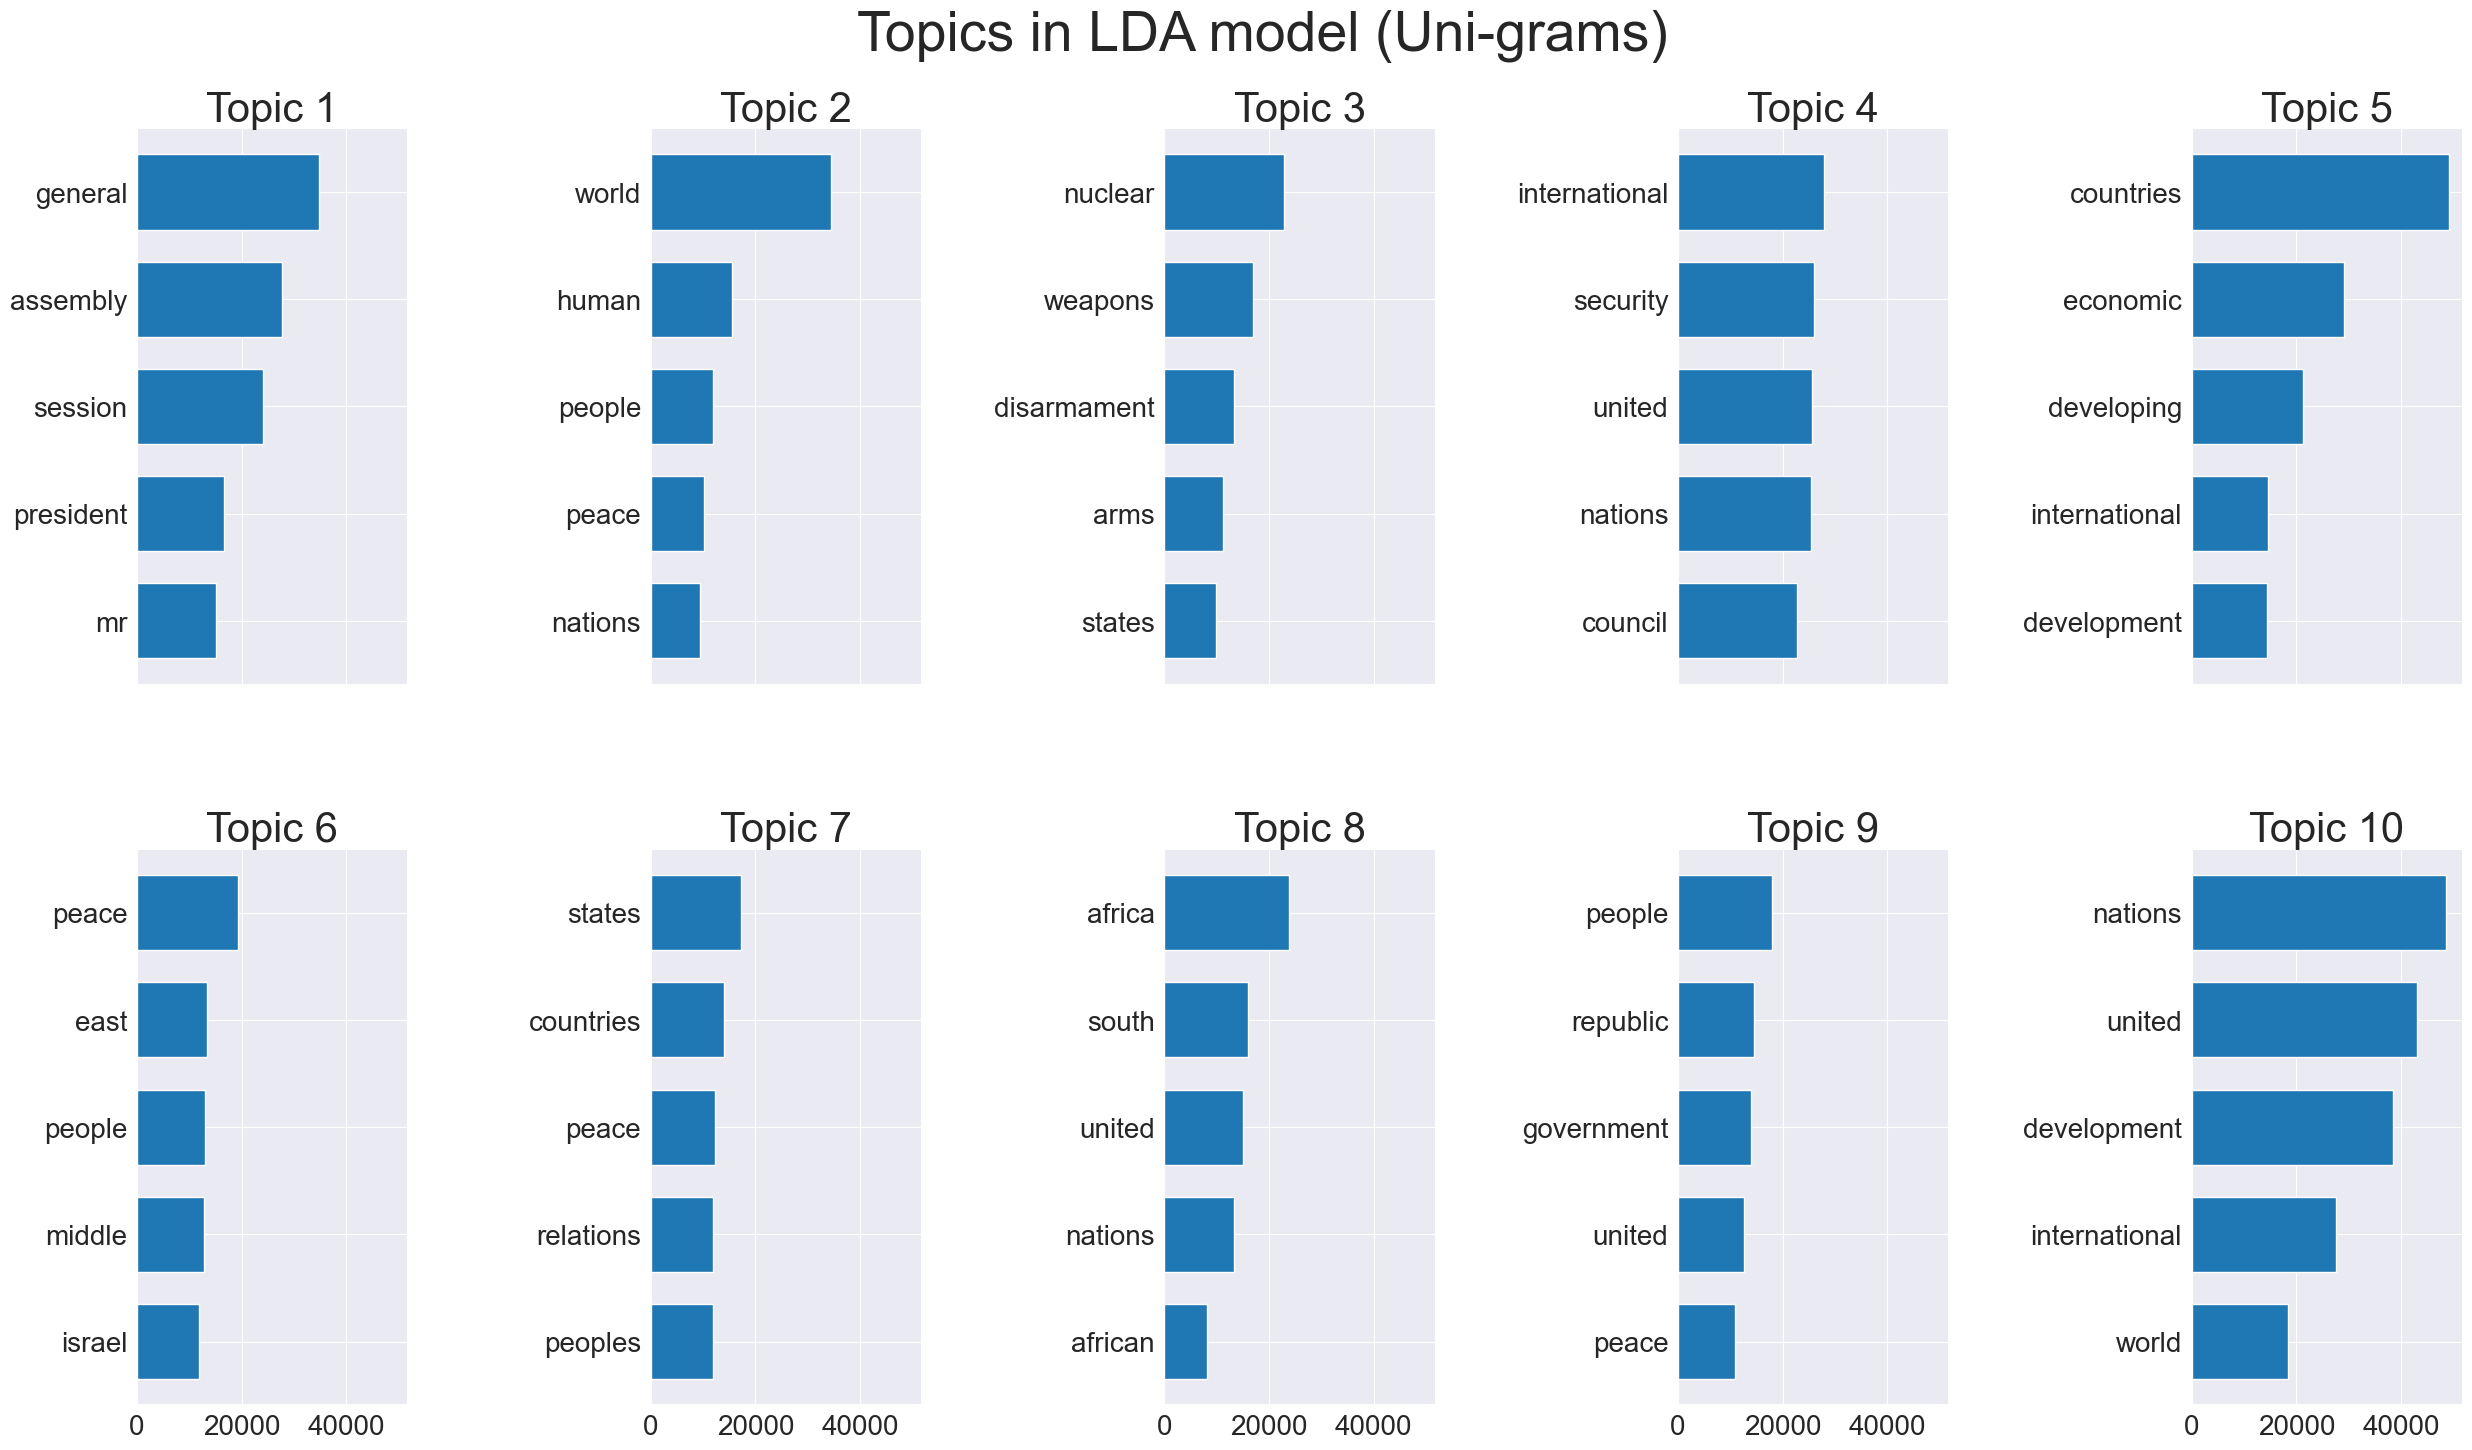

In [71]:
plot_top_words(
    model=lda_para_model,
    feature_names=count_para_vectorizer.get_feature_names_out(),
    n_top_words=5,
    title="Topics in LDA model (Uni-grams)"
)

In [68]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 9.14716924, 13.03694125,  7.012396  , 11.32457192,  9.2946125 ,
        8.86826234,  8.94118744,  7.10875204,  9.61481304, 15.65129423])

In [75]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model_bigrams = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix_bigrams = lda_para_model_bigrams.fit_transform(count_para_vectors_bigrams)
H_lda_para_matrix_bigrams = lda_para_model_bigrams.components_

In [ ]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()




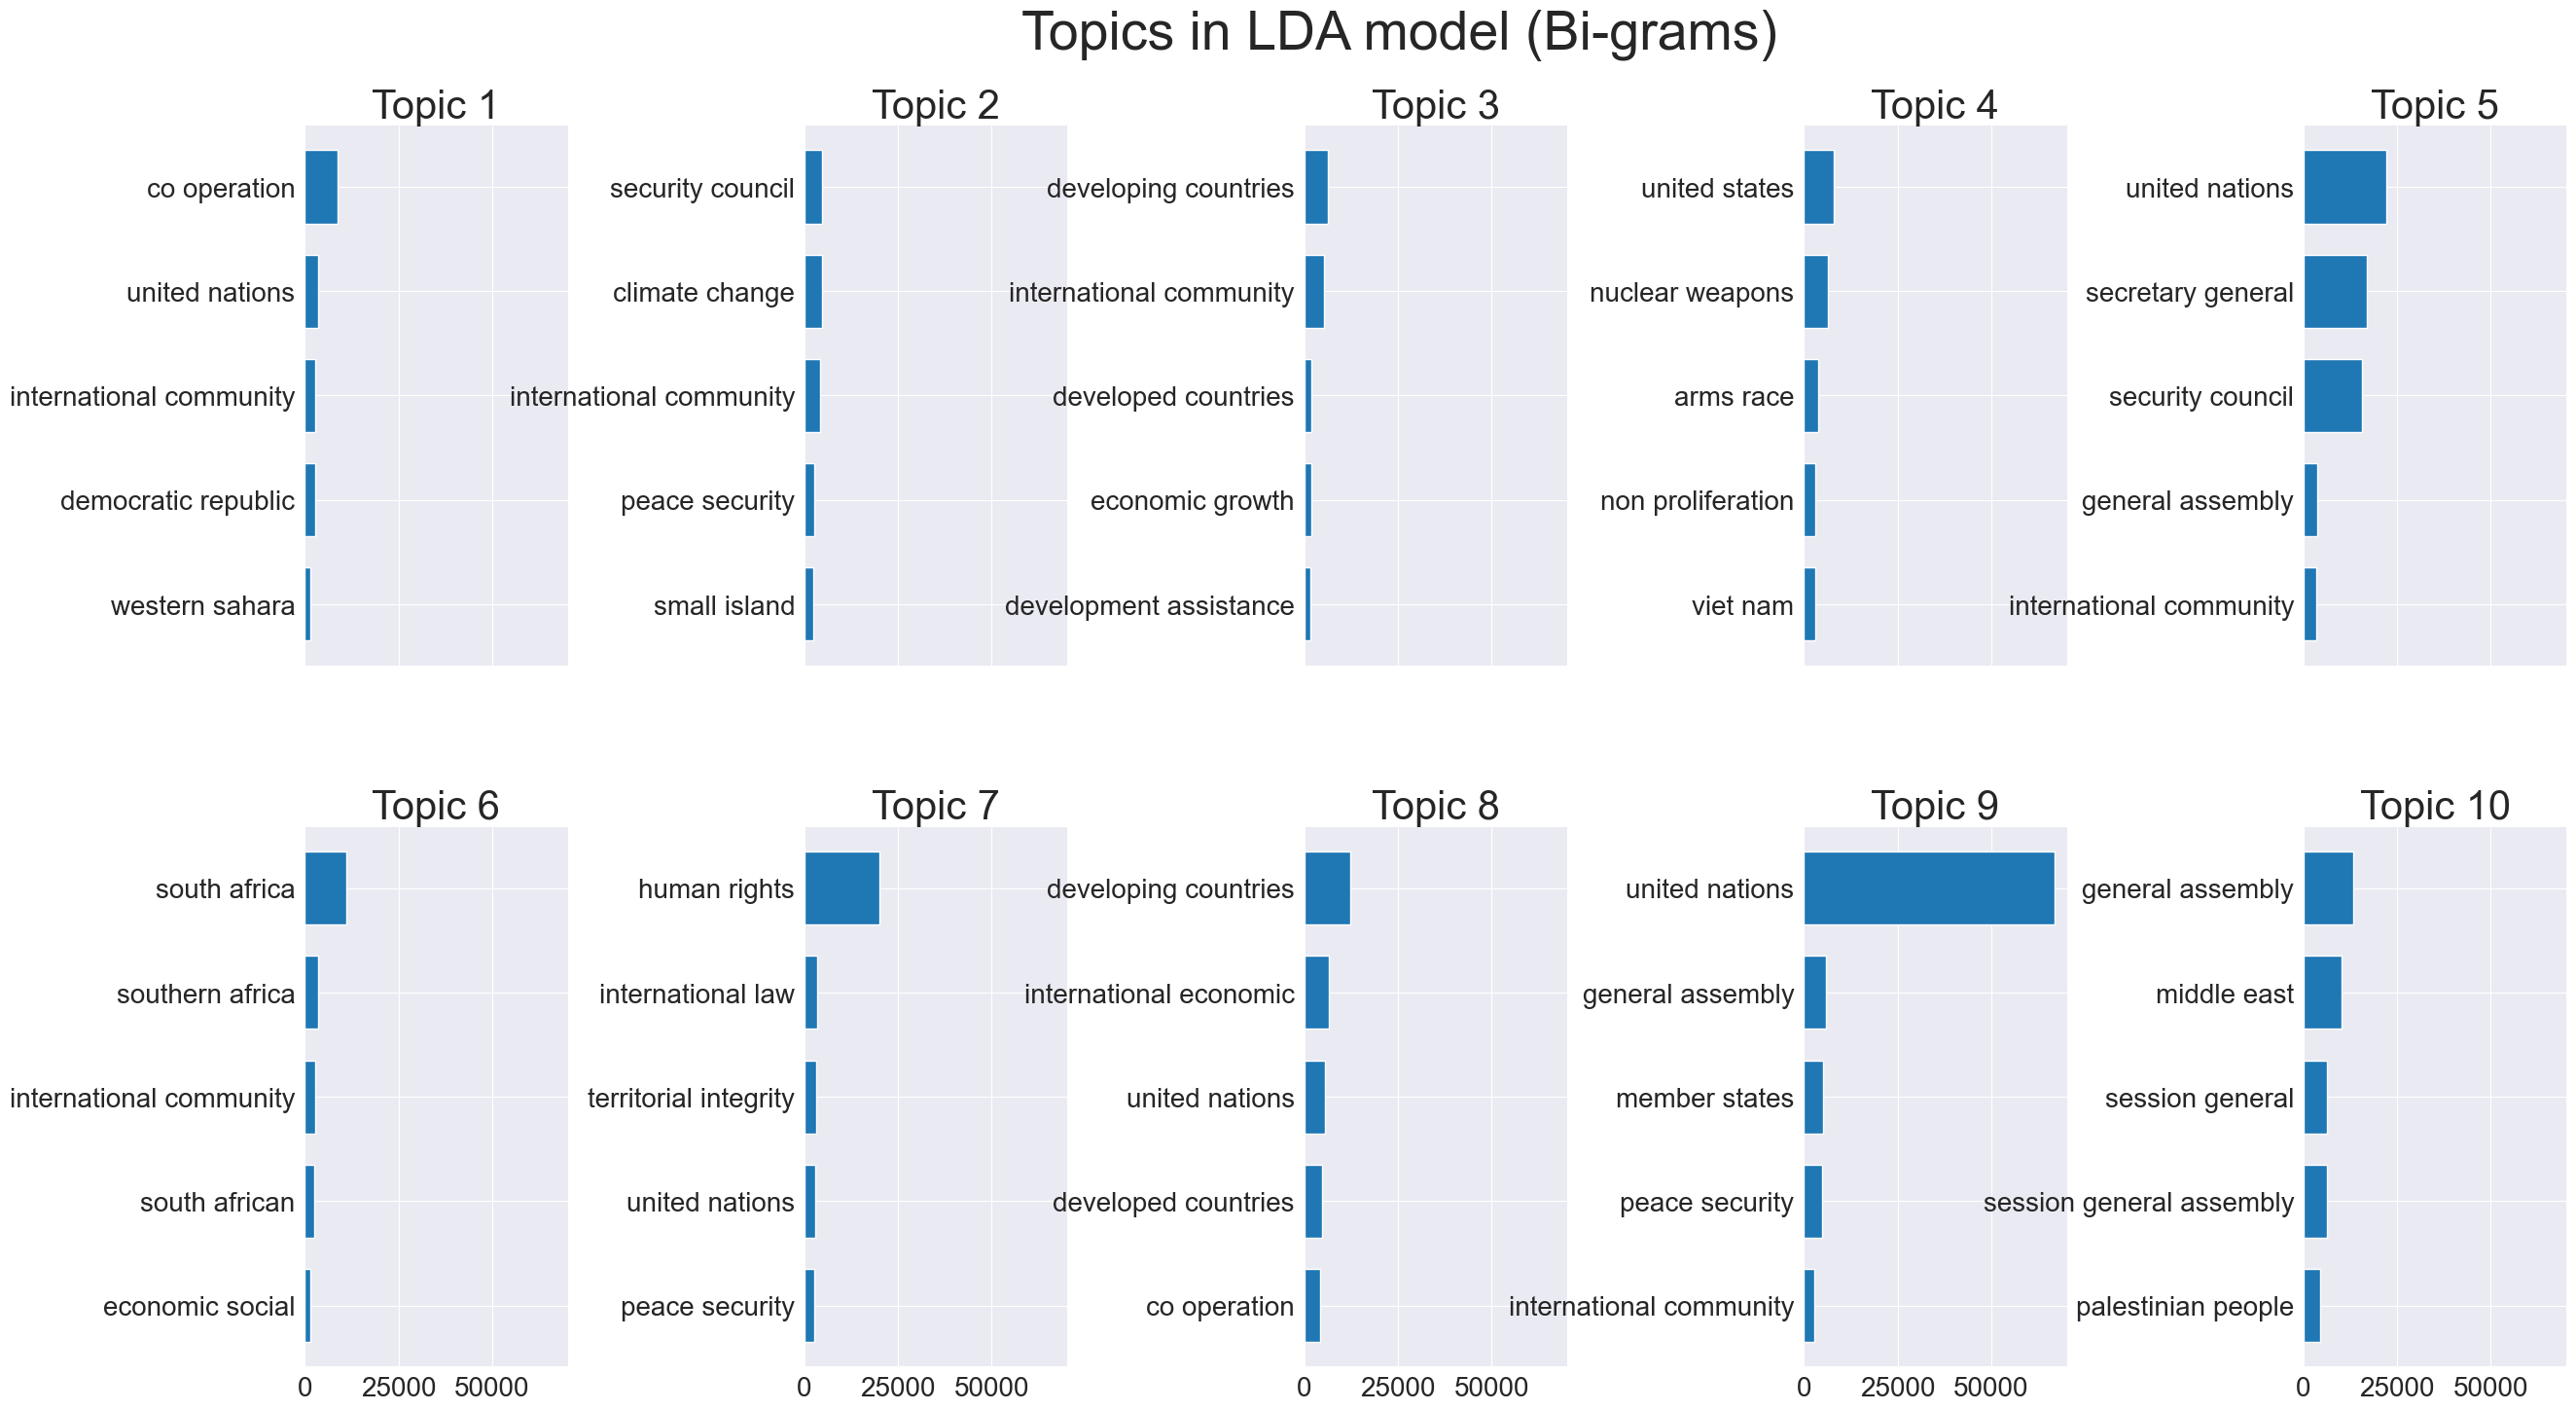

In [82]:
plot_top_words(
    model=lda_para_model_bigrams,
    feature_names=count_para_vectorizer_bigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in LDA model (Bi-grams)"
)

In [81]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
#pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'docs/models/lda.html')

In [83]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model_bigrams, count_para_vectors_bigrams, count_para_vectorizer_bigrams, sort_topics=False)
#pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'docs/models/lda_bigrams.html')

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is depre

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/shanekercheval/repos/nlp-template/.venv/lib/pytho